# 07. Force Matching 

In [4]:
import hoomd, hoomd.htf as htf, hoomd.md
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf

In [6]:
# Build the graph
graph = htf.graph_builder(63)
nlist = graph.nlist[:, :, :3]
# get r
r = tf.norm(nlist, axis=2)
# compute 1 / r while safely treating r = 0.
# pairwise energy. Double count -> divide by 2
epsilon = tf.Variable(0.5, name='lj-epsilon', trainable=True)
sigma = tf.Variable(0.5, name='lj-sigma', trainable=True)
inv_r6 = graph.safe_div(sigma**2, r**2)
p_energy = epsilon / 2.0 * (- inv_r6)
# sum over pairwise energy
energy = tf.reduce_sum(p_energy, axis=1, name='energy')
computed_forces = graph.compute_forces(energy)
# get target forces without leading variables
# sigma2 = tf.Variable(1.0, trainable=False)
inv_r62 = graph.safe_div(1.0, r**2)
p_energy2 = 1.0 / 2.0 * (- inv_r62)
energy2 = tf.reduce_sum(p_energy2, axis=1, name='energy2')
target_forces = graph.compute_forces(energy2)
minimizer, loss = htf.force_matching(target_forces[:,:3], 
                                         computed_forces[:,:3])
graph.save_tensor(loss, 'cost')
graph.save(force_tensor=computed_forces,
           model_directory='CG_tutorial/force_matching',
           out_nodes=[epsilon, sigma])

Note: Backed-up CG_tutorial/force_matching previous model to CG_tutorial/force_matching/previous_model_0


In [14]:
# run the simulation
model_dir = 'CG_tutorial/force_matching'
hoomd.context.initialize("--mode=cpu")
with hoomd.htf.tfcompute(model_dir) as tfcompute:
    N = 64
    NN = 63
    rcut = 7.5
    system = hoomd.init.create_lattice(
        unitcell=hoomd.lattice.sq(a=4.0),
        n=[4,4])
    nlist = hoomd.md.nlist.cell(check_period=1)
    hoomd.md.integrate.mode_standard(dt=0.005)
    hoomd.md.integrate.nve(group=hoomd.group.all(
            )).randomize_velocities(kT=2, seed=2)
    tfcompute.attach(nlist, r_cut=rcut, save_period=10)
    hoomd.run(1000)
    input_nlist = tfcompute.get_nlist_array()

notice(2): Started TF Session Manager.
notice(2): Group "all" created containing 16 particles
notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
INFO:tensorflow:The following quantities will computed:
INFO:tensorflow:	name period batch
INFO:tensorflow:	 lj-epsilon:0 1 None
INFO:tensorflow:	 lj-sigma:0 1 None
INFO:tensorflow:	 AssignAdd:0 1 None
INFO:tensorflow:	 Assign:0 1 None
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-1000
notice(2): TF Session Manager has released control. Starting HOOMD updates
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 16
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 593 / 1000 | TPS 59.2746 | ETA 00:00:06
Time 00:00:17 | Step 1000 / 100

INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-0
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-10
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-20
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-30
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-40
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-50
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-60
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-70
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-80
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-90
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-100
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-110
INFO:tensorflow:Restoring parameters from CG_tutorial/force_mat

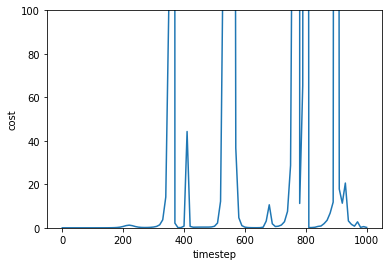

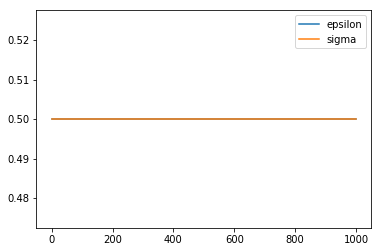

In [20]:
time = np.arange(0, 1001, 10)
cost = np.empty(len(time))
epsilon = np.empty(len(time))
sigma = np.empty(len(time))
for i, t in enumerate(time):
    variables = hoomd.htf.load_variables(model_dir, names = ['cost', 'lj-epsilon', 'lj-sigma'], checkpoint = int(t), feed_dict=dict({'nlist-input:0':input_nlist}))
    cost[i] = variables['cost']
    epsilon[i] = variables['lj-epsilon']
    sigma[i] = variables['lj-sigma']
    
plt.plot(time, cost) #, label = 'cost')
plt.xlabel('timestep')
plt.ylabel('cost')
plt.ylim(0, 100)
plt.show()

plt.plot(time, epsilon, label = 'epsilon')
plt.plot(time, sigma, label = 'sigma')
plt.legend()
plt.show()

In [22]:
tf.trainable_variables()

[<tf.Variable 'lj-epsilon:0' shape=() dtype=float32_ref>,
 <tf.Variable 'lj-sigma:0' shape=() dtype=float32_ref>]